# Face tracking with rotations using Mediapipe
<br>
<div align="center">Wim Pouw (wim.pouw@donders.ru.nl)</div>

<img src="Images/envision_banner.png" alt="isolated" width="300"/>

<img src="Images/output_example.gif" alt="isolated" width="300"/>

## Info documents

Mediapipe is a versatile package with very user-friendly installation process and fast tracking. It also has a face tracker, but in comparison to other computer vision methods it does not have head rotations. This can be problematic as for example for head nodding or shaking it would be best to express such behavior along a rotation of the x (for nodding; also called pitch) or y (for shaking; also called yaw) axes. Also you might want to study head turn directions. Or you may want to make sure there are not head rotations. 

Luckily, through some linear algebra applied to the facemesh data you can get this information. Here we will track the face with a 3D facemesh (next to hands and body), but we also add the rotation data in degrees for the nose. This python notebook runs you through the procedure of taking videos as inputs with a single person in the video, and outputting the facemesh coordinates with head rotations added based on a solution proposed overviewed by [Susanne Thierfelder](https://medium.com/@susanne.thierfelder/head-pose-estimation-with-mediapipe-and-opencv-in-javascript-c87980df3acb).

We make use of the Holistic Tracking by Google's Mediapipe to track the face (and you can uncomment the code to add other modalities), similar to our  on envisionBOX [masking module](https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/Mediapipe_Optional_Masking). We then implemented the very nice solution of estimating head rotations from the facemesh points.

* location current Repository: https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/MediaPipeFaceRotation/

* location Jupyter notebook: https://github.com/WimPouw/envisionBOX_modulesWP/blob/main/MediaPipeFaceRotation/face_tracking_rotations.ipynb

## Additional information backbone of the tool (Mediapipe Holistic Tracking)
https://google.github.io/mediapipe/solutions/holistic.html

### Citation for Mediapipe
citation: Lugaresi, C., Tang, J., Nash, H., McClanahan, C., Uboweja, E., Hays, M., ... & Grundmann, M. (2019). Mediapipe: A framework for building perception pipelines. arXiv preprint arXiv:1906.08172.

### Citation for Susanne Thierfelder solution
Thierfelder, S. (2024, 19-4). Head Pose Estimation with MediaPipe and OpenCV in JavaScript. Medium. https://medium.com/@susanne.thierfelder/head-pose-estimation-with-mediapipe-and-opencv-in-javascript-c87980df3acb

### Citation for current implementation
Pouw, W. (2024). Wim Pouw's EnvisionBOX modules for social signal processing (Version 1.0.0) [Computer software]. https://github.com/WimPouw/envisionBOX_modulesWP

### Modification that is the basis of this tool
Our modification here is just the implementation of Susanne Thierfelders solution in the envisionBox workflow by adapting the mediapipe tracking pipeline we already have in envisionBOX. Here we track the hands, body, and facemesh adding head rotations.

### Use
Make sure to install all the packages in requirements.txt. Then move your videos that you want to mask into the input folder. Then run this code, which will loop through all the videos contained in the input folder; and saves all the results in the output folders.

Please use, improve and adapt as you see fit.

In [4]:
#load in required packages
import mediapipe as mp #mediapipe
import cv2 #opencv
import math #basic operations
import numpy as np #basic operations
import pandas as pd #data wrangling
import csv #csv saving
import os #some basic functions for inspecting folder structure etc.

#list all videos in input_videofolder
from os import listdir
from os.path import isfile, join
#time series output folder
inputfol = "./Input_Videos/"
vfiles = [f for f in listdir(inputfol) if isfile(join(inputfol, f))] #loop through the filenames and collect them in a list
outputf = "./Output_Videos/"
outtputf_ts = "./Output_TimeSeries/"

# we also have some sanity check data from OpenFace
sanity_check = pd.read_csv("./Sanity_check_data/openface_data.csv")

#check videos to be processed
print("The following folder is set as the output folder where all the pose time series are stored")
print(os.path.abspath(outtputf_ts))
print("\n The following folder is set as the output folder for saving the masked videos ")
print(os.path.abspath(outputf))
print("\n The following video(s) will be processed for masking: ")
print(vfiles)

The following folder is set as the output folder where all the pose time series are stored
C:\Users\u668173\Desktop\wimpouwenvisionboxwp\envisionBOX_modulesWP\MediaPipeFaceRotation\Output_TimeSeries

 The following folder is set as the output folder for saving the masked videos 
C:\Users\u668173\Desktop\wimpouwenvisionboxwp\envisionBOX_modulesWP\MediaPipeFaceRotation\Output_Videos

 The following video(s) will be processed for masking: 
['WIN_20240419_10_25_17_Pro.mp4']


In [5]:
#initialize modules and functions

#load in mediapipe modules
mp_holistic = mp.solutions.holistic
# Import drawing_utils and drawing_styles.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

##################FUNCTIONS AND OTHER VARIABLES
#landmarks 33x that are used by Mediapipe (Blazepose)
markersbody = ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_OUTER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER',
          'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 
          'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
          'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE',
          'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']

markershands = ['LEFT_WRIST', 'LEFT_THUMB_CMC', 'LEFT_THUMB_MCP', 'LEFT_THUMB_IP', 'LEFT_THUMB_TIP', 'LEFT_INDEX_FINGER_MCP',
              'LEFT_INDEX_FINGER_PIP', 'LEFT_INDEX_FINGER_DIP', 'LEFT_INDEX_FINGER_TIP', 'LEFT_MIDDLE_FINGER_MCP', 
               'LEFT_MIDDLE_FINGER_PIP', 'LEFT_MIDDLE_FINGER_DIP', 'LEFT_MIDDLE_FINGER_TIP', 'LEFT_RING_FINGER_MCP', 
               'LEFT_RING_FINGER_PIP', 'LEFT_RING_FINGER_DIP', 'LEFT_RING_FINGER_TIP', 'LEFT_PINKY_FINGER_MCP', 
               'LEFT_PINKY_FINGER_PIP', 'LEFT_PINKY_FINGER_DIP', 'LEFT_PINKY_FINGER_TIP',
              'RIGHT_WRIST', 'RIGHT_THUMB_CMC', 'RIGHT_THUMB_MCP', 'RIGHT_THUMB_IP', 'RIGHT_THUMB_TIP', 'RIGHT_INDEX_FINGER_MCP',
              'RIGHT_INDEX_FINGER_PIP', 'RIGHT_INDEX_FINGER_DIP', 'RIGHT_INDEX_FINGER_TIP', 'RIGHT_MIDDLE_FINGER_MCP', 
               'RIGHT_MIDDLE_FINGER_PIP', 'RIGHT_MIDDLE_FINGER_DIP', 'RIGHT_MIDDLE_FINGER_TIP', 'RIGHT_RING_FINGER_MCP', 
               'RIGHT_RING_FINGER_PIP', 'RIGHT_RING_FINGER_DIP', 'RIGHT_RING_FINGER_TIP', 'RIGHT_PINKY_FINGER_MCP', 
               'RIGHT_PINKY_FINGER_PIP', 'RIGHT_PINKY_FINGER_DIP', 'RIGHT_PINKY_FINGER_TIP']
facemarks = [str(x) for x in range(478)] #there are 478 points (see google holistic face mesh info for landmarks)

print("Note that we have the following number of pose keypoints for markers body")
print(len(markersbody))

print("\n Note that we have the following number of pose keypoints for markers hands")
print(len(markershands))

print("\n Note that we have the following number of pose keypoints for markers face")
print(str(len(facemarks )) + '  !!!plus three rotation values!!!')

#set up the column names and objects for the time series data (add time as the first variable)
markerxyzbody = ['time']
markerxyzhands = ['time']
markerxyzface = ['time']

for mark in markersbody:
    for pos in ['X', 'Y', 'Z', 'visibility']: #for markers of the body you also have a visibility reliability score
        nm = pos + "_" + mark
        markerxyzbody.append(nm)
for mark in markershands:
    for pos in ['X', 'Y', 'Z']:
        nm = pos + "_" + mark
        markerxyzhands.append(nm)
for mark in facemarks:
    for pos in ['X', 'Y', 'Z']:
        nm = pos + "_" + mark
        markerxyzface.append(nm)

# we also add rotations x, y, z to the facemarks
markerxyzface = markerxyzface + ['face_rotation_X', 'face_rotation_Y', 'face_rotation_Z']

#check if there are numbers in a string
def num_there(s):
    return any(i.isdigit() for i in s)

#take some google classification object and convert it into a string
def makegoginto_str(gogobj):
    gogobj = str(gogobj).strip("[]")
    gogobj = gogobj.split("\n")
    return(gogobj[:-1]) #ignore last element as this has nothing

#make the stringifyd position traces into clean numerical values
def listpostions(newsamplemarks):
    newsamplemarks = makegoginto_str(newsamplemarks)
    tracking_p = []
    for value in newsamplemarks:
        if num_there(value):
            stripped = value.split(':', 1)[1]
            stripped = stripped.strip() #remove spaces in the string if present
            tracking_p.append(stripped) #add to this list  
    return(tracking_p)

Note that we have the following number of pose keypoints for markers body
33

 Note that we have the following number of pose keypoints for markers hands
42

 Note that we have the following number of pose keypoints for markers face
478  !!!plus three rotation values!!!


In [6]:
# do you want to apply masking?
masking = False
#We will now loop over all the videos that are present in the video file
for vidf in vfiles:
    print("We will now process video:")
    print(vidf)
    print("This is video number" + str(vfiles.index(vidf))+ "of" + str(len(vfiles)) + "videos in total")
    #capture the video, and check video settings
    videoname = vidf
    videoloc = inputfol + videoname
    capture = cv2.VideoCapture(videoloc) #load in the videocapture
    frameWidth = capture.get(cv2.CAP_PROP_FRAME_WIDTH) #check frame width
    frameHeight = capture.get(cv2.CAP_PROP_FRAME_HEIGHT) #check frame height
    samplerate = capture.get(cv2.CAP_PROP_FPS)   #fps = frames per second

    #make an 'empty' video file where we project the pose tracking on
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') #for different video formats you could use e.g., *'XVID'
    out = cv2.VideoWriter(outputf+videoname, fourcc, 
                          fps = samplerate, frameSize = (int(frameWidth), int(frameHeight)))

    # Run MediaPipe frame by frame using Holistic with `enable_segmentation=True` to get pose segmentation.
    time = 0
    tsbody = [markerxyzbody]   #these will be your time series objects, which start with collumn names initialized above
    tshands = [markerxyzhands] #these will be your time series objects, which start with collumn names initialized above
    tsface = [markerxyzface]   #these will be your time series objects, which start with collumn names initialized above

    with mp_holistic.Holistic(
            static_image_mode=False, enable_segmentation=True, refine_face_landmarks=True) as holistic:
        while (True):
            ret, image = capture.read() #read frame
            if ret == True: #if there is a frame
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #make sure the image is in RGB format
                results = holistic.process(image) #apply Mediapipe holistic processing                
                # Draw pose segmentation
                h, w, c = image.shape
                face_3d = []
                face_2d = []
                if  np.all(results.face_landmarks) != None: #check if there is a pose found
                    if masking == False:
                        original_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    if masking == True:
                        original_image = np.concatenate([image, np.full((h, w, 1), 255, dtype=np.uint8)], axis=-1)
                        mask_img = np.zeros_like(image, dtype=np.uint8) #set up basic mask image
                        mask_img[:, :] = (255,255,255) #set up basic mask image
                        segm_2class = 0.2 + 0.8 * results.segmentation_mask #set up a segmentation of the results of mediapipe
                        segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2) #set up a segmentation of the results of mediapipe
                        annotated_image = mask_img * segm_2class * (1 - segm_2class) #take the basic mask image and make a sillhouette mask
                        # append Alpha channel to sillhouetted mask so that we can overlay it to the original image
                        mask = np.concatenate([annotated_image, np.full((h, w, 1), 255, dtype=np.uint8)], axis=-1)
                        # Zero background where we want to overlay
                        original_image[mask==0]=0 #for the original image we are going to set everything at zero for places where the mask has to go
                        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
                    #R for the head we also estimate rotations
                    for idx, lm in enumerate(results.face_landmarks.landmark):
                        if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                            if idx == 1:
                                nose_2d = (lm.x * w, lm.y * h)
                                nose_3d = (lm.x * w, lm.y * h, lm.z * 3000)
                            x, y = int(lm.x * w), int(lm.y * h)
                            face_2d.append([x, y])
                            face_3d.append([x, y, lm.z])
                    #R Convert it to the NumPy array
                    face_2d = np.array(face_2d, dtype=np.float64)

                    #R Convert it to the NumPy array
                    face_3d = np.array(face_3d, dtype=np.float64)  

                    #R camera matrix
                    focal_length = 1*w
                    cam_matrix =  np.array([ [focal_length, 0, h / 2],
                                    [0, focal_length, w / 2],
                                    [0, 0, 1]])
                    #R The distortion parameters
                    dist_matrix = np.zeros((4, 1), dtype=np.float64)

                    #R Solve the PnP problem
                    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

                    #R Get rotational matrix
                    rmat, jac = cv2.Rodrigues(rot_vec)
                    
                    #R Get angles in normalized units
                    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
                    
                    # Decompose projection matrix to get Euler angles (to check out)
                    proj_matrix = np.hstack((rmat, trans_vec))
                    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(proj_matrix)

                    # Convert to degrees
                    xrot, yrot, zrot = euler_angles.flatten()
                    rotationsx = [xrot, yrot, zrot]

                    # Get the rotation degree
                    xrot = angles[0] * w # up and down
                    yrot = angles[1] * h # left and right
                    zrot = angles[2] * 3000 # tilt
                    rotations = [xrot, yrot, zrot]
                   
                    #R Display the nose direction
                    nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vec, trans_vec, cam_matrix, dist_matrix)
                    p1 = (int(nose_2d[0]), int(nose_2d[1]))
                    p2 = (int(nose_2d[0] + yrot * 30) , int(nose_2d[1] - xrot * 30))    # the constant integers deterimines the length of the line
                    cv2.line(original_image, p1, p2, (0, 0, 200), 7)
                    # Add the text on the image
                    cv2.putText(original_image, "x pitch/headraise: " + str(np.round(xrot,2)), (450, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 200), 2)
                    cv2.putText(original_image, "y yaw/headturn: " + str(np.round(yrot,2)), (450, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 200), 2)
                    cv2.putText(original_image, "z roll/headtilt: " + str(np.round(zrot,2)), (450, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 200), 2)
                    
                    #now lets draw on the original_image the left and right hand landmarks, the facemesh and the body poses
                        #left hand
                    mp_drawing.draw_landmarks(original_image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                        #right hand
                    mp_drawing.draw_landmarks(original_image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                        #face
                    mp_drawing.draw_landmarks(
                            original_image,
                            results.face_landmarks,
                            mp_holistic.FACEMESH_TESSELATION,
                            landmark_drawing_spec=None,
                            connection_drawing_spec=mp_drawing_styles
                            .get_default_face_mesh_tesselation_style())
                        #body (lets no draw the body, so that we can see the facemesh better)
                    #mp_drawing.draw_landmarks(
                    #        original_image,
                    #        results.pose_landmarks,
                    #        mp_holistic.POSE_CONNECTIONS,
                    #        landmark_drawing_spec=mp_drawing_styles.
                    #        get_default_pose_landmarks_style())
                    #######################now save everything to a time series
                        #make a variable list with x, y, z, info where data is appended to
                    samplebody = listpostions(results.pose_world_landmarks) # we are saving it in body centered estimates in real world coordinates (meters)
                    samplehands = listpostions([results.left_hand_landmarks, results.right_hand_landmarks])
                    sampleface = listpostions(results.face_landmarks)
                    samplebody.insert(0, time)
                    samplehands.insert(0, time)
                    sampleface.insert(0, time)
                    tsbody.append(samplebody)   #append to the timeseries object
                    tshands.append(samplehands) #append to the timeseries object
                    tsface.append(sampleface)   #append to the timeseries object
                    # add the rotations
                    tsface[-1].extend(rotations)
                # we are going add NAN values if no face is detected
                if np.all(results.face_landmarks) == None:
                    original_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    # add empy row of DATA NA
                    samplebody = [np.nan for x in range(len(markerxyzbody)-1)]
                    samplehands = [np.nan for x in range(len(markerxyzhands)-1)]
                    sampleface = [np.nan for x in range(len(markerxyzface)-1)]
                    samplebody.insert(0, time)
                    samplehands.insert(0, time)
                    sampleface.insert(0, time)
                    tsbody.append(samplebody)   #append to the timeseries object
                    tshands.append(samplehands) #append to the timeseries object
                    tsface.append(sampleface)   #append to the timeseries object
                #show the video as we process (you can comment this out, if you want to run this process in the background)
                cv2.imshow("resizedimage", original_image)
                out.write(original_image) #save the frame to the new masked video
                time = time+(1000/samplerate)#update the time variable  for the next frame
            if cv2.waitKey(1) == 27: #allow the use of ESCAPE to break the loop
                   break
            if ret == False: #if there are no more frames, break the loop
                break

    #once done de-initialize all processes
    out.release()
    capture.release()
    cv2.destroyAllWindows()
     ####################################################### data to be written row-wise in csv fil
    # opening the csv file in 'w+' mode
    filebody = open(outtputf_ts + vidf[:-4]+'_body.csv', 'w+', newline ='')
    #write it
    with filebody:    
        write = csv.writer(filebody)
        write.writerows(tsbody)
     # opening the csv file in 'w+' mode
    filehands = open(outtputf_ts + vidf[:-4]+'_hands.csv', 'w+', newline ='')
    #write it
    with filehands:
        write = csv.writer(filehands)
        write.writerows(tshands)
    # opening the csv file in 'w+' mode
    fileface = open(outtputf_ts + vidf[:-4]+'_face.csv', 'w+', newline ='')
    #write it
    with fileface:    
        write = csv.writer(fileface)
        write.writerows(tsface)

print("Done with processing all folders; go look in your output folders!")    

We will now process video:
WIN_20240419_10_25_17_Pro.mp4
This is video number0of1videos in total
Done with processing all folders; go look in your output folders!


# Comparing to openface data
The solutions that we have tried out here have not been compared against a more popular solution for face tracking called openface. A colleague who studies Sign Language and expert in using Open Face, Vadim Kimmelman, has kindly provided some openface output for this video to compare to the current mediapipe solution. Below you will see that the data covary reliably, though the scaling and offset is much closer to 1:1 for the yaw (head shake) time series. For the pitch data you see that the scaling and offsets are a bit different suggesting that either openface or mediapipe has some distortions. The roll data we should intrepret with caution as as there is little head tilt in this data so not much variance to scout the relationship. All in all, also given the visual accuracy shown in the mediapipe video, the current solution can be an interesting and rebost enough method for tracking gross changes in head rotation (e.g., useful for quantifying and detecting head shakes and head nods).

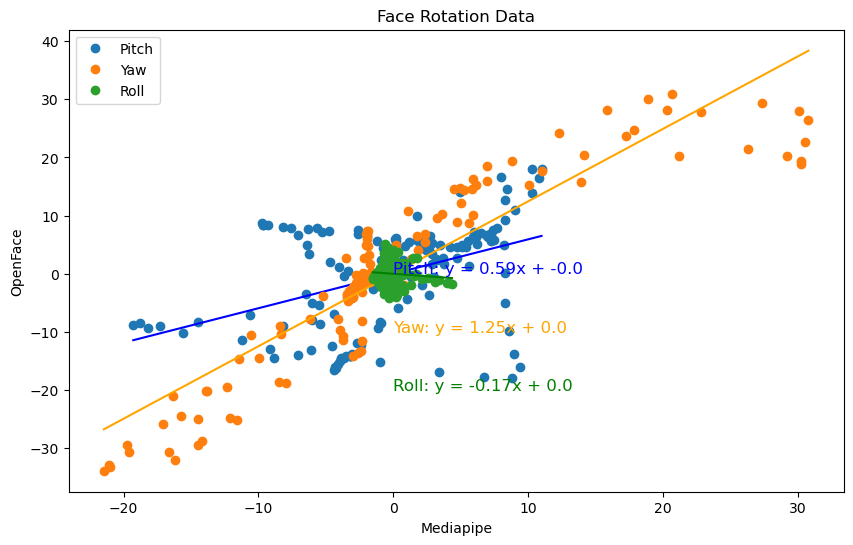

In [7]:
import glob as glob
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# now load in the data and check if the demo data is correct relative to openface
# check for face data
facefiles = glob.glob(outtputf_ts + "*_face.csv")
# load in face file
face = pd.read_csv(facefiles[0])
# extract the yaw data
pitch_cur = face['face_rotation_X']
yaw_cur = face['face_rotation_Y']
roll_cur = face['face_rotation_Z']
# load openface data for sanity checking
sanity_check.head()
pitch_openface = sanity_check[' pose_Rx']
yaw_openface = sanity_check[' pose_Ry']
roll_openface = sanity_check[' pose_Rz']
    # smooth the data with savitsky golay filter
pitch_cur = savgol_filter(pitch_cur*-1, 11, 3) # -1, as we now say right hand rule relative to the camera (openface)
yaw_cur = savgol_filter(yaw_cur*-1, 11, 3) # -1, as we now say so we now say right hand rule relative to the camera (openface)
roll_cur = savgol_filter(roll_cur*-1, 11, 3) # -1, so we now say right hand rule relative to the camera (openface)
    # convert to degrees
pitch_openface = np.rad2deg(pitch_openface)
yaw_openface = np.rad2deg(yaw_openface)
roll_openface = np.rad2deg(roll_openface)
    # smooth the data with savitsky golay filter
pitch_openface = savgol_filter(pitch_openface, 11, 3)
yaw_openface = savgol_filter(yaw_openface, 11, 3)
roll_openface = savgol_filter(roll_openface,11, 3)

# center the data if you want to cancel the offsets
pitch_cur = pitch_cur - np.mean(pitch_cur)
yaw_cur = yaw_cur - np.mean(yaw_cur)
roll_cur = roll_cur - np.mean(roll_cur)
pitch_openface = pitch_openface - np.mean(pitch_openface)
yaw_openface = yaw_openface - np.mean(yaw_openface)
roll_openface = roll_openface - np.mean(roll_openface)

# get the beta of the slopes
beta_pitch = np.polyfit(pitch_cur, pitch_openface, 1)
beta_yaw = np.polyfit(yaw_cur, yaw_openface, 1)
beta_roll = np.polyfit(roll_cur, roll_openface, 1)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot pitch data and linear regression line
plt.plot(pitch_cur, pitch_openface, 'o', label='Pitch')
plt.plot(np.unique(pitch_cur), np.poly1d(np.polyfit(pitch_cur, pitch_openface, 1))(np.unique(pitch_cur)), color='blue')

# Plot yaw data and linear regression line
plt.plot(yaw_cur, yaw_openface, 'o', label='Yaw')
plt.plot(np.unique(yaw_cur), np.poly1d(np.polyfit(yaw_cur, yaw_openface, 1))(np.unique(yaw_cur)), color='orange')

# Plot roll data and linear regression line
plt.plot(roll_cur, roll_openface, 'o', label='Roll')
plt.plot(np.unique(roll_cur), np.poly1d(np.polyfit(roll_cur, roll_openface, 1))(np.unique(roll_cur)), color='green')

# Add the beta of the slopes and the constant offset
plt.text(0, 0, 'Pitch: y = ' + str(round(beta_pitch[0], 2)) + 'x + ' + str(round(beta_pitch[1], 2)), fontsize=12, color='blue')
plt.text(0, -10, 'Yaw: y = ' + str(round(beta_yaw[0], 2)) + 'x + ' + str(round(beta_yaw[1], 2)), fontsize=12, color='orange')
plt.text(0, -20, 'Roll: y = ' + str(round(beta_roll[0], 2)) + 'x + ' + str(round(beta_roll[1], 2)), fontsize=12, color='green')

# Labels and legend
plt.title('Face Rotation Data')
plt.xlabel('Mediapipe')
plt.ylabel('OpenFace')
plt.legend()
plt.show()

In [ ]:
#